Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


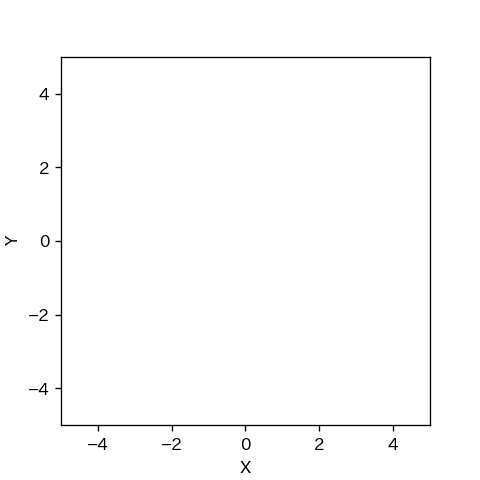

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


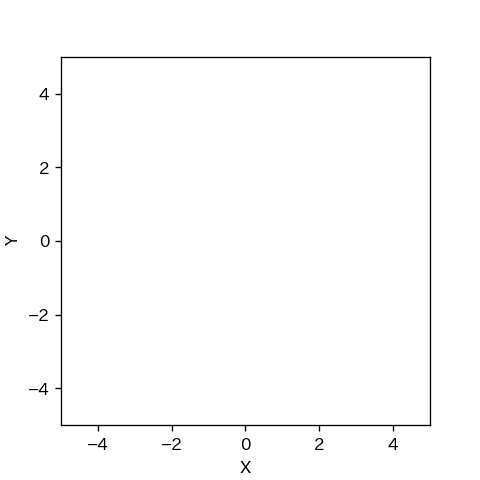

(array([ 0.831775  ,  0.83900085, -0.53771849]),
 array([ 2.5004338 , -2.76065226, -0.97806047]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[1.148149702945361]
0 真値: [ 0.32816197 -2.20786047  5.36191623] 推定値: [ 0.19222937 -2.17805455  5.34840015] 誤差: 0.13916201460734293
1
[4.056064312349597]
1 真値: [-0.12076775  0.81257321  4.64165005] 推定値: [-0.13445777  0.43590865  4.6125651 ] 誤差: 0.3769132555893283
2
[4.079391558362881]
[6.31292463492552]
2 真値: [-0.69252859  4.21729497  7.95319414] 推定値: [6.25678638 0.38831324 4.21351268] 誤差: 7.934360706285331
[1.6864557786043766]
3 真値: [1.6675752  2.35031045 4.88552008] 推定値: [1.68691738 2.20230831 4.77164676] 誤差: 0.14926069352881102
3
[1.029238735434954]
4 真値: [-2.45816226  3.54454394  3.61487916] 推定値: [-2.19333791  3.29469291  3.47307517] 誤差: 0.36408444365804515
4
[1.36756626809019]
5 真値: [-5.67379083  0.15048785  6.0241903 ] 推定値: [-6.52222447  1.6373139   4.68257434] 誤差: 1.7118677945893794
6 真値: [-4.23180939 -0.62228396  4.60465104] 推定値: [-4.23779779 -0.30924638  4.88334151] 誤差: 0.3130948553812549
5
[1.35548754956286]
7 真値: [ 4.54202224 -1.62852531  2.21238616] 推定値: [ 4.553798   -0.3776

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[1.5215414902903304]
20 真値: [ 5.08393177 -3.27956285  2.35882502] 推定値: [ 0.64324753 -1.01454888  4.51009673] 誤差: 4.9849739067338446
[7.250144869450172]
[7.979027939789381, 4.786594417490166]
21 真値: [-2.3703597  -1.60427282  2.59282554] 推定値: [-2.07611057 -2.48402535  2.51476323] 誤差: 0.9276567657363292
12
[2.698656879712734]
22 真値: [ 2.57578973 -5.69465671  5.92686834] 推定値: [ 4.18945039 -1.5240438   1.58123559] 誤差: 4.471902591667228
[2.030528727059221]
23 真値: [3.16328982 3.530585   6.88284644] 推定値: [2.65969916 2.67519928 3.46581617] 誤差: 0.9926168863712335
13
24 真値: [-0.43665227 -4.91282283  5.8092059 ] 推定値: [ 5.5965099  -3.75029379  7.38480354] 誤差: 6.144145147549478
[4.4071483676020975]
25 真値: [3.01263992 5.16107772 5.12528434] 推定値: [1.10003266 1.71242637 1.02256161] 誤差: 3.9435089294211125
[3.063076274456116]
26 真値: [4.90846867 0.91820961 2.76258533] 推定値: [3.8970551  0.49574375 2.32167659] 誤差: 1.0960998188161373
[1.2929369592563051]
27 真値: [ 4.14017777 -2.61017416  2.21208729] 推定値: [ 3.8